<a href="https://colab.research.google.com/github/ianforrest11/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do exploratory visualizations with Seaborn.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a linear regression model with multiple features.
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# Convert to datetime and look at the date range
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

In [0]:
# create subset of data for home sales between $100,000 and $2mil
df = df[(df['SALE_PRICE'] >= 100000) & (df['SALE_PRICE'] <= 2000000)]

In [42]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,2019-01-01
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,2019-01-01
65,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,691,1130,NaN,R4,"505 WEST 19TH STREET, 7D",7D,10011.0,1.0,0.0,1.0,"18,975",1077.0,2013.0,2,R4,2000000,2019-01-02
66,1,MIDTOWN EAST,10 COOPS - ELEVATOR APARTMENTS,2,1347,18,NaN,D4,"345 EAST 54TH ST, 3B",NaN,10022.0,0.0,0.0,0.0,0,0.0,1960.0,2,D4,330000,2019-01-02
67,1,UPPER EAST SIDE (79-96),10 COOPS - ELEVATOR APARTMENTS,2,1491,62,NaN,D4,"16 EAST 80TH STREET, 2A",NaN,10075.0,0.0,0.0,0.0,0,0.0,1925.0,2,D4,600000,2019-01-02


In [46]:
# create train/test datasets by assigning cutoff date of April 1, 2019 to 'SALE_DATE' column
cutoff = pd.to_datetime('2019-04-01')
train = df[df.SALE_DATE < cutoff]
test  = df[df.SALE_DATE >= cutoff]
train.shape, test.shape

((10488, 21), (2983, 21))

In [58]:
df['BUILDING_CLASS_CATEGORY'].value_counts().sort_index()

01 ONE FAMILY DWELLINGS                       3164
02 TWO FAMILY DWELLINGS                       2440
03 THREE FAMILY DWELLINGS                      658
04 TAX CLASS 1 CONDOS                          300
05 TAX CLASS 1 VACANT LAND                     134
06 TAX CLASS 1 - OTHER                          26
07 RENTALS - WALKUP APARTMENTS                 238
08 RENTALS - ELEVATOR APARTMENTS                 8
09 COOPS - WALKUP APARTMENTS                   587
10 COOPS - ELEVATOR APARTMENTS                2781
11A CONDO-RENTALS                               11
12 CONDOS - WALKUP APARTMENTS                  193
13 CONDOS - ELEVATOR APARTMENTS               1758
14 RENTALS - 4-10 UNIT                          60
15 CONDOS - 2-10 UNIT RESIDENTIAL              295
16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT      14
17 CONDO COOPS                                 249
21 OFFICE BUILDINGS                             30
22 STORE BUILDINGS                              72
23 LOFT BUILDINGS              

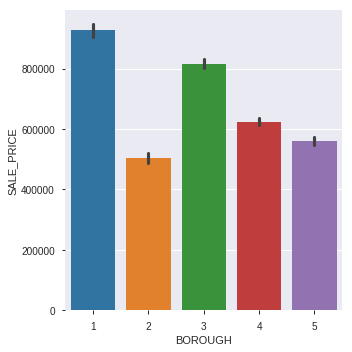

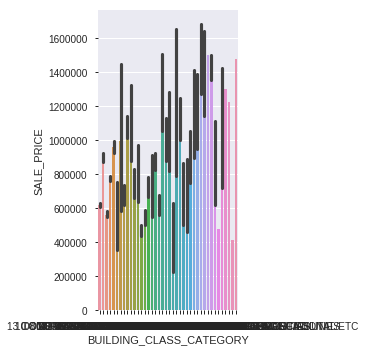

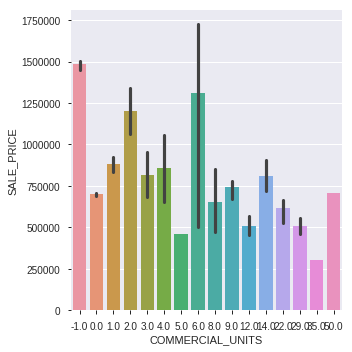

ValueError: ignored

In [51]:
# exploratory visualization
for col in sorted(train.columns):
    if train[col].nunique() < 50:
        sns.catplot(x=col, y='SALE_PRICE', data=train, kind='bar')
        plt.show()

In [59]:
# one-hot encoding of training set - BUILDING_CLASS_CATEGORY column
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
encoded = encoder.fit_transform(train['BUILDING_CLASS_CATEGORY'])
encoded.head()



,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING_CLASS_CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_44 CONDO PARKING,BUILDING_CLASS_CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING_CLASS_CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING_CLASS_CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING_CLASS_CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING_CLASS_CATEGORY_17 CONDO COOPS,BUILDING_CLASS_CATEGORY_29 COMMERCIAL GARAGES,BUILDING_CLASS_CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING_CLASS_CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_27 FACTORIES,BUILDING_CLASS_CATEGORY_22 STORE BUILDINGS,BUILDING_CLASS_CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING_CLASS_CATEGORY_45 CONDO HOTELS,BUILDING_CLASS_CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING_CLASS_CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING_CLASS_CATEGORY_06 TAX CLASS 1 - OTHER,BUILDING_CLASS_CATEGORY_46 CONDO STORE BUILDINGS,BUILDING_CLASS_CATEGORY_21 OFFICE BUILDINGS,BUILDING_CLASS_CATEGORY_37 RELIGIOUS FACILITIES,BUILDING_CLASS_CATEGORY_33 EDUCATIONAL FACILITIES,BUILDING_CLASS_CATEGORY_30 WAREHOUSES,BUILDING_CLASS_CATEGORY_11A CONDO-RENTALS,BUILDING_CLASS_CATEGORY_36 OUTDOOR RECREATIONAL FACILITIES,BUILDING_CLASS_CATEGORY_34 THEATRES,BUILDING_CLASS_CATEGORY_16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,BUILDING_CLASS_CATEGORY_26 OTHER HOTELS,BUILDING_CLASS_CATEGORY_28 COMMERCIAL CONDOS,BUILDING_CLASS_CATEGORY_35 INDOOR PUBLIC AND CULTURAL FACILITIES,BUILDING_CLASS_CATEGORY_39 TRANSPORTATION FACILITIES,BUILDING_CLASS_CATEGORY_42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,BUILDING_CLASS_CATEGORY_23 LOFT BUILDINGS
44,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
61,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
65,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [63]:
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)

target = 'SALE_PRICE'
features = train_subset.columns.drop(target)
X_train = train_subset[features]
y_train = train_subset[target]
X_test  = test_subset[features]
y_test  = test_subset[target]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10488, 9), (10488,), (2983, 9), (2983,))

In [65]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=5)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

X_train_selected.shape, X_test_selected.shape

((10488, 5), (2983, 5))

In [66]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\nFeatures not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH
BLOCK
LOT
RESIDENTIAL_UNITS
GROSS_SQUARE_FEET

Features not selected:
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
TAX_CLASS_AT_TIME_OF_SALE


In [70]:
# generate Linear Regression Model, intercept, & co-efficients
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
model.fit(X_train_selected, y_train)
y_pred = model.predict(X_test_selected)
print(model.intercept_)
print(model.coef_)

943927.8802460502
[-5.04444461e+04 -2.07469846e+01  1.25690767e+01  1.12818433e+04
  8.63921570e-01]


In [73]:
from sklearn.preprocessing import StandardScaler

target = 'SALE_PRICE'
#high_cardinality = ['display_address', 'street_address', 'description', 'created']
#features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $315,776 

2 features
Test MAE: $315,412 

3 features
Test MAE: $314,925 

4 features
Test MAE: $313,128 

5 features
Test MAE: $313,049 

6 features
Test MAE: $313,002 

7 features
Test MAE: $312,482 

8 features
Test MAE: $310,358 

9 features
Test MAE: $310,336 

